### WeRateDogs Twitter Archive

The goal of this project is to wrangle and analyze the tweets and retweet counts of dog ratings data. WeRateDogs is a great archive, but appears to contain very basic information with regard to the tweet counts, etc..

The missing tweet stats can be completed by making use of the Twitter API where we can query for a given tweet ID and Twitter API will return us a JSON data with other information regarding the tweet.

We are also provided with image predictions of what breed a particular dog belongs to, in a separate file on image_predictions.tsv. These predictions are run using a Neural network.

Below we first import the necessary libraries for the data wrangling exercise

In [1]:
import pandas as pd
import numpy as np
import csv
import json
import requests
import tweepy
import re
from wrangle_utils import *

#### NOTE on helper methods and utilities:

All methods that are used by this notebook are defined in file wrangle_utils.py saved in the same archive.

### Data that we have:


We are already provided with the following datasets:
1. Tweet data from the WerateDogs Twitter Archive - in a .csv file (twitter-archive-enhanced.csv).
2. Predictions from a neural network model that details predictions of dog breed and the score of the predictions. This is from a tsv file saved at "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

First I am going to get the data that we already have. Then, later for the missing information and tweet info, we can make use of the tweepy library to get tweet data from twitter.

### Gathering Data - Initial steps

In [2]:
weratedogs_twitter_archive_data = pd.read_csv("twitter-archive-enhanced.csv")

In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
predictions = get_predictions_file(url)

In [4]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null object
p1_dog      2075 non-null object
p2          2075 non-null object
p2_conf     2075 non-null object
p2_dog      2075 non-null object
p3          2075 non-null object
p3_conf     2075 non-null object
p3_dog      2075 non-null object
dtypes: object(12)
memory usage: 194.6+ KB


## Assessing Data

Here is a snapshot of the first few rows in the dataset.

In [5]:
weratedogs_twitter_archive_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Now let's check for Null values in the twitter_archive data.
From visual inspection of the .csv file, we find that one of the columns that has got null values is the 'expanded_urls' column. 59 null values in the expanded_urls column.

In [6]:
weratedogs_twitter_archive_data[weratedogs_twitter_archive_data.expanded_urls.isnull()].shape

(59, 17)

In [7]:
weratedogs_twitter_archive_data[weratedogs_twitter_archive_data.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [8]:
weratedogs_twitter_archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Below is an assessment of the data stored in the **weratedogs_twitter_archive_data** dataframe.

**Quallity**



- "timestamp" column in werate_dogs_twitter_data is of type str. Converting this to object timestamp can be useful for us while analyzing the data.

- Missing values in columns in_reply_to_user_id, in_reply_to_status_id, retweeted_user_id, retweeted_status_timestamp. Are these columns very critical if we aren't really taking the retweet direction?

- retweeted_status_id is of "np.float64" datatype. Convert to int64.

- Missing "expanded_urls" values. What do we do with these rows? We can impute these rows.

- dog names Null values: 'name' column contains values such as "None". It appears that the parsing of the names haven't been successful. We can treat these as missing values.
- dog names unclean values: There are values in the 'name' column such as "a", "getting", "actually", etc.. These are not real dog names. These appear to be errors from trying to parse out the names of dogs.
- Some "tweet_id" values result in missing/non-existing tweets and are in some cases wrong tweet IDs. For example: in index #21, Tweet ID: 888202515573088257 doesnt exist. We can however attempt to get the details of this tweet from the expanded_url column.

- There are some unclean data with the Rating Numerators and denominators. There is one tweet with a rating of 9/10 but the numerator and denominator columns are 24,7 respectively and 1 tweet with a denominator value equals to 0. These appear to be parsing errors.<br>

- There are some values of rating denominators in the dataset that are as high as 170. The corresponding rating numerator for this dog is 204. This clearly indicates that the dog is rated at 12/10 or a 120 on a percentage score basis. Standardinzing will help us with analysis.<br>

- Also, there are some rows in the data set where decimal ratings of the numerators are wrongly parsed. For example, tweet ID: 883482846933004288 actually has a ranking of 13.5, but it is wrongly parsed as 5.<br>
 
- Outlier Values in rating numerators: Some dogs are rated very highly or probably there is a clear bias or is done as a joke, such as the one that is rated at 420/10 or 1776/10. <br>




**Tidiness**

- After standardization, Column "rating_denominator" becomes redundant. We can drop this column and convert rating_numerator to a standardized rating column.
-  Columns doggo, floofer, pupper, puppo are values and not variable names; this violates the 3rd rule of Tidy data. Each observational unit does not form a table.
- Column "source" in the WeRateDogsTwitter Archive data contains two variables, the website reference of the source and the description of the source as a HTML tag.
- Column 'expanded_urls' contains multiple URLs, some of which are repetitions of the same photo URLs. 

## Clean

Data WeRateDogs Twitter Archive: **weratedogs_twitter_archive**

**Quality Issues**

**Define**:

- Convert "timestamp" column to datetime object using pandas to_datetime method.

- Delete columns retweeted_status_user_id, retweeted_status_timestamp from the dataframe.

- Convert retweeted_status_id from "np.float64" datatype to int64. Fill null values in these columns   with value -1.

- Impute rows where 'expanded_urls' have null values.

- replace bad data for dog name with data from the tweet text. The value to search for and the value to replace with are found in file missing_dog_names.csv.

- Some "tweet_id" values result in missing/non-existing tweets and are in some cases wrong tweet IDs. For such tweet IDs replace tweet_id with the tweet_id found in the expanded_url column. I will try to achieve this when I query the twitter API below. These values will be retrieved later while querying the twitter API under section "Gathering Data - Getting data from twitter API".

- We aren't really using retweet data. There are rows in the dataset that correspond to retweeted tweets. These rows can be removed from the dataset.
  These columns will be removed from the dataset after queries to Twitter API are done. I am postponing this to the end of my data cleaning.


**Code**

In [11]:
from datetime import datetime

In [12]:
weratedogs_twitter_archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
weratedogs_copy = weratedogs_twitter_archive_data.copy()
weratedogs_copy['retweeted_status_id'] = weratedogs_copy['retweeted_status_id'].fillna(-1).astype(np.int64)
weratedogs_copy = weratedogs_copy.drop(["retweeted_status_user_id","retweeted_status_timestamp"], axis=1)
weratedogs_copy["timestamp"] = pd.to_datetime(weratedogs_copy["timestamp"], errors='coerce')
weratedogs_copy =  weratedogs_copy[~weratedogs_copy['expanded_urls'].isnull()]


In [14]:
# Cleans and fills in dog names.
clean_dog_names = pd.read_csv("missing_dog_names.csv")
clean_dog_names.head()

,index_num,search,replace_with
0,649,a,Forrest
1,1955,a,Kip
2,2034,a,Jacob
3,2066,a,Rufus
4,2116,a,Spork


In [15]:
for index, row in clean_dog_names.iterrows():
    ind_num = row['index_num']
    weratedogs_copy.loc[ind_num,"name"] = row['replace_with']

In [16]:
weratedogs_copy.loc[weratedogs_copy.name == "a","name"] = "None"

**Test**

In [17]:
weratedogs_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2297 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2297 non-null datetime64[ns]
source                   2297 non-null object
text                     2297 non-null object
retweeted_status_id      2297 non-null int64
expanded_urls            2297 non-null object
rating_numerator         2297 non-null int64
rating_denominator       2297 non-null int64
name                     2297 non-null object
doggo                    2297 non-null object
floofer                  2297 non-null object
pupper                   2297 non-null object
puppo                    2297 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 367.1+ KB


In [18]:
weratedogs_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,-1,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,-1,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,-1,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,-1,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,-1,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [19]:
weratedogs_copy.loc[[649,1955],"name"]

649      Forrest
1955         Kip
Name: name, dtype: object

#### Cleaning and Standardizing Dog ratings

The WeRateDogs Twitter Archive data contains observations where the rating values are not parsed properly. As an example, lets look at TweetID: 666287406224695296. The tweet text for this tweet gives a rating of 9/10, but however a rating of 1/2 is parsed wrongly. 

For this, we can clean-up these rating values programattically by setting up a search-and-replace dictionary __ratings_search_replace__, that would replace the existing incorrect pair of rating numerator and rating denominator with the actual numerator and denominator.

In [20]:
# A search and replace dictionary is used to replace with the correct ratings values.
ratings_search_replace = [{"rating_values_existing":(1,2), "rating_values_replace":(9,10)},
                          {"rating_values_existing":(960,0), "rating_values_replace":(13,10)},
                          {"rating_values_existing":(7,11), "rating_values_replace":(10,10)},
                          {"rating_values_existing":(960,0), "rating_values_replace":(13,10)},
                          {"rating_values_existing":(9,11), "rating_values_replace":(14,10)}]

for item in ratings_search_replace: 

    condition = (weratedogs_copy.rating_denominator == item["rating_values_existing"][1]) & (weratedogs_copy.rating_numerator == item["rating_values_existing"][0])
    weratedogs_copy.loc[condition,"rating_denominator"] = item["rating_values_replace"][1]
    weratedogs_copy.loc[condition,"rating_numerator"] = item["rating_values_replace"][0]

Here we Test if the values are correct:

In [21]:
assert ((weratedogs_copy.rating_denominator == ratings_search_replace[0]["rating_values_existing"][1]) & (weratedogs_copy.rating_numerator == ratings_search_replace[0]["rating_values_existing"][0])).sum() == 0
assert ((weratedogs_copy.rating_denominator == ratings_search_replace[1]["rating_values_existing"][1]) & (weratedogs_copy.rating_numerator == ratings_search_replace[1]["rating_values_existing"][0])).sum() == 0
assert ((weratedogs_copy.rating_denominator == ratings_search_replace[2]["rating_values_existing"][1]) & (weratedogs_copy.rating_numerator == ratings_search_replace[2]["rating_values_existing"][0])).sum() == 0

#### Parse out decimal Ratings

Also, parsing of rating_numerator havent been very efficient. There appears to be an issue with parsing decimal rating values.


In [22]:
decimal_rating_nums = weratedogs_copy[weratedogs_copy.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

c:\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


We see that there are 5 rows in the dataset that have missed out the decimal ratings.

In [24]:
decimal_rating_nums

,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
340,"RT @dog_rates: This is Logan, the Chow who liv...",75
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1712,Here we have uncovered an entire battalion of ...,26


In [25]:

for ind,k in decimal_rating_nums.iterrows():
    print (k["text"])

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [26]:
decimal_rating_nums["Corrected"] = pd.Series([13.5, 9.75, 9.75,11.27, 11.26],index=decimal_rating_nums.index)

In [27]:
for ind,k in decimal_rating_nums.iterrows():
    
    weratedogs_copy.loc[ind,"rating_numerator"] = k["Corrected"]

In [28]:
weratedogs_copy.loc[45,"rating_numerator"]

13.5

Now that our values have been made correct, we make sure that our rating is standardized, such that a rating of 120/100 is same as 12/10. Although, WeRateDogs may not like this standardization to make the denominator equals to 10, it helps with our analysis though, without losing much information.

So Now, we set the numerator proportional to denominator multiplied by 10. 

In [29]:
weratedogs_copy.loc[weratedogs_copy.rating_denominator > 10,"rating_numerator"] = 10*(weratedogs_copy.loc[weratedogs_copy.rating_denominator > 10,"rating_numerator"])/(weratedogs_copy.loc[weratedogs_copy.rating_denominator > 10, "rating_denominator"])
weratedogs_copy.loc[weratedogs_copy.rating_denominator > 10,"rating_denominator"] = 10

#### Test

In [30]:
weratedogs_copy.rating_denominator.unique()
weratedogs_copy.rating_numerator = weratedogs_copy.rating_numerator.astype(np.int64)
weratedogs_copy.rating_numerator.unique()

array([  13,   12,   14,   11,   10,    6,   15,    0,    9,    7,   24,
          8,    1,    5,    3,    4, 1776,    2,  420], dtype=int64)

We still do find that there are some very large values in the ratings numerator column. I am going to drop these, since these would potentially be outliers for our analysis.

In [31]:
values_to_remove = [75,420,666,1776,182]
weratedogs_copy = weratedogs_copy[~weratedogs_copy.rating_numerator.isin(values_to_remove)]

In [32]:
weratedogs_twitter_archive_data = weratedogs_copy

#### Clean: Drop rows with retweet data

In [33]:
weratedogs_copy = weratedogs_twitter_archive_data.copy()

Retweeted Tweets are rows that do not have a retweeted_status_id = -1. Thus, we take the complement of this set of rows.

In [34]:
weratedogs_copy = weratedogs_copy[weratedogs_copy.retweeted_status_id == -1]

In [35]:
weratedogs_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2115 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2115 non-null datetime64[ns]
source                   2115 non-null object
text                     2115 non-null object
retweeted_status_id      2115 non-null int64
expanded_urls            2115 non-null object
rating_numerator         2115 non-null int64
rating_denominator       2115 non-null int64
name                     2115 non-null object
doggo                    2115 non-null object
floofer                  2115 non-null object
pupper                   2115 non-null object
puppo                    2115 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 264.4+ KB


In [36]:
weratedogs_twitter_archive_data = weratedogs_copy

**Tidiness Issues**:

**Define**


**1.** Drop column "rating_denominator" and rename "rating_numerator" to "standardized_rating".


**2.** 
"source" column violates the principle of tidy data. __Each variable forms a column.__. There are 2 variables contained in the "source" variable. Use regular expressions to filter for the URL and the source description from each row.


**3.**
Columns doggo, floofer, pupper, puppo are variable values and not variable names. These column names are values to a dog stage. A value of True in Column doggo indicates that this particular dog is in the "doggo" stage.
More about dog lingo here: https://www.rover.com/blog/everything-you-need-to-know-about-doggo-lingo/
Create a new column "dog stage" that outputs the 'non-None' value in these 4 columns to one value. Remove columns 'doggo', 'floofer', 'pupper', 'puppo'.

**4.** 
I am going to postpone clearing the tidiness issue for expanded_urls. This will be done once the data from Twitter API is retrieved.

**Code**

In [37]:
weratedogs_copy = weratedogs_twitter_archive_data.copy()

Drop the Rating Denominator column.

In [38]:
weratedogs_copy = weratedogs_copy.drop("rating_denominator",axis=1)
weratedogs_copy = weratedogs_copy.rename(index=str, columns= {"rating_numerator":"standardized_rating"})

In [39]:
weratedogs_copy.columns.values

array(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'retweeted_status_id',
       'expanded_urls', 'standardized_rating', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'], dtype=object)

In [40]:
weratedogs_copy["source_description"] = pd.Series([(re.findall('\>([^\<]*)\<\/a\>',x)[0]).rstrip() for x in weratedogs_copy["source"].values], index=weratedogs_copy.index)
weratedogs_copy["source_urls"] = pd.Series([(re.findall('\<a href=\"([^\"]*)\"',x)[0]).rstrip() for x in weratedogs_copy["source"].values] , index=weratedogs_copy.index)

In [41]:
weratedogs_copy = weratedogs_copy.drop(columns=['source'])

In [42]:
weratedogs_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'expanded_urls', 'standardized_rating',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'source_description',
       'source_urls'],
      dtype='object')

In [43]:
weratedogs_copy = weratedogs_copy[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
                                   'source_urls', 'source_description','text', 'retweeted_status_id', 'expanded_urls', 'standardized_rating',
                                   'name', 'doggo', 'floofer', 'pupper', 'puppo',
                                   ]]

In [44]:
weratedogs_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source_urls,source_description,text,retweeted_status_id,expanded_urls,standardized_rating,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,-1,https://twitter.com/dog_rates/status/892420643...,13,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,Twitter for iPhone,This is Tilly. She's just checking pup on you....,-1,https://twitter.com/dog_rates/status/892177421...,13,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,-1,https://twitter.com/dog_rates/status/891815181...,12,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,-1,https://twitter.com/dog_rates/status/891689557...,13,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,Twitter for iPhone,This is Franklin. He would like you to stop ca...,-1,https://twitter.com/dog_rates/status/891327558...,12,Franklin,None,None,None,None


We find that columns "doggo", "floofer", etc.. contain values "None" (as in string not Type), which indicates an absence of value. Also there are 14 rows in the dataset that have multiple dog life stages.

In [45]:
dog_stages = weratedogs_copy[["doggo","floofer","pupper","puppo"]]
((dog_stages != "None").sum(axis=1)).value_counts()

0    1777
1     326
2      12
dtype: int64

In [46]:
dog_stages["doggo"].replace("None","",inplace=True)
dog_stages["floofer"].replace("None","",inplace=True)
dog_stages["pupper"].replace("None","",inplace=True)
dog_stages["puppo"].replace("None","",inplace=True)

c:\python37\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [47]:
cols = ["doggo","floofer","pupper","puppo"]
dog_stage = []
for index, row in dog_stages.iterrows():
    stage_val = ""
    for k in cols:
        if row[k]:
            stage_val = stage_val + "-" + row[k]
    stage_val = stage_val.strip('-')
    dog_stage.append(stage_val)
            

In [48]:
weratedogs_copy["dog_stage"] = pd.Series(dog_stage,index=weratedogs_copy.index)
weratedogs_copy.loc[weratedogs_copy["dog_stage"] == "","dog_stage"] = "None"
weratedogs_copy = weratedogs_copy.drop(columns = ["doggo","floofer","pupper","puppo"])
weratedogs_twitter_archive_data = weratedogs_copy
weratedogs_twitter_archive_data.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source_urls', 'source_description', 'text', 'retweeted_status_id',
       'expanded_urls', 'standardized_rating', 'name', 'dog_stage'],
      dtype='object')

## Gathering Data - Getting data from Twitter API

In this section, we grab twitter data from the Twitter API for each tweet ID listed in the weratedogs twitter Archive. There appears to be some tweet ID's from our original twitter archive csv file, for which the tweets have been deleted. Such tweets do not carry other info, such as # of Retweets, likes etc.. I have collected such tweets in file "unauthorized_tweet_ids.csv". For example, Tweet ID 680055455951884288 appears to be deleted.

There also appear to be certain Tweet ID's that do not contain a valid ID, however, the retweet ID/the tweet ID found in the media URL is valid and turns out that these tweets are not really retweets and are tweeted by User @dog_rates.
For example, tweet ID: 770743923962707968 doesnt exist. URL: https://twitter.com/dog_rates/status/770743923962707968 doesnt exist. However, the media URLs associated with this row in archive returns a valid tweet, which is at the website:
https://twitter.com/dog_rates/status/739238157791694849/video/1 , where we see this dog blowing bubbles :) 
The below code collects the JSON object pertaining to the tweet ID found from the Media URL/ retweeted ID.



In [ ]:
api = get_twitter_API()

In [50]:

output_json_obj = []

file_handle = open("unauthorized_tweet_ids.csv","w")

unauthorized_csv = csv.writer(file_handle, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL,lineterminator="\n")
headers = ["index","tweet_id","retweet_status_id","status_id_from_media_url"]
unauthorized_csv.writerow(headers)
count = 0

for index,row in weratedogs_twitter_archive_data.iterrows():
    
    print ("Fetching Tweet API data from row #: {}".format(int(index)+1))
    json_obj = get_json_data(api,row)
   
    if not json_obj:
        unauthorized_csv.writerow([int(index)+1, row["tweet_id"],row["retweeted_status_id"],get_tweet_id_from_urls(row["expanded_urls"])])
    
    output_json_obj.append(json_obj)

file_handle.close()



Fetching Tweet API data from row #: 1
Fetching Tweet API data from row #: 2
Fetching Tweet API data from row #: 3
Fetching Tweet API data from row #: 4
Fetching Tweet API data from row #: 5
Fetching Tweet API data from row #: 6
Fetching Tweet API data from row #: 7
Fetching Tweet API data from row #: 8
Fetching Tweet API data from row #: 9
Fetching Tweet API data from row #: 10
Fetching Tweet API data from row #: 11
Fetching Tweet API data from row #: 12
Fetching Tweet API data from row #: 13
Fetching Tweet API data from row #: 14
Fetching Tweet API data from row #: 15
Fetching Tweet API data from row #: 16
Fetching Tweet API data from row #: 17
Fetching Tweet API data from row #: 18
Fetching Tweet API data from row #: 19
Fetching Tweet API data from row #: 21
Fetching Tweet API data from row #: 22
Fetching Tweet API data from row #: 23
Fetching Tweet API data from row #: 24
Fetching Tweet API data from row #: 25
Fetching Tweet API data from row #: 26
Fetching Tweet API data from row #

Fetching Tweet API data from row #: 252
Fetching Tweet API data from row #: 253
Fetching Tweet API data from row #: 254
The Tweet ID: 844704788403113984 does not exist in the Twitter API
Trying Tweet ID from the Media URL: 844704788403113984
The Tweet ID: 844704788403113984 does not exist in the Twitter API
Unable to fetch Tweet IDs
Fetching Tweet API data from row #: 255
Fetching Tweet API data from row #: 256
Fetching Tweet API data from row #: 257
Fetching Tweet API data from row #: 258
Fetching Tweet API data from row #: 259
Fetching Tweet API data from row #: 260
Fetching Tweet API data from row #: 262
Fetching Tweet API data from row #: 263
Fetching Tweet API data from row #: 264
Fetching Tweet API data from row #: 265
Fetching Tweet API data from row #: 266
Fetching Tweet API data from row #: 268
Fetching Tweet API data from row #: 269
Fetching Tweet API data from row #: 270
Fetching Tweet API data from row #: 271
Fetching Tweet API data from row #: 272
Fetching Tweet API data f

Fetching Tweet API data from row #: 516
Fetching Tweet API data from row #: 517
Fetching Tweet API data from row #: 518
Fetching Tweet API data from row #: 519
Fetching Tweet API data from row #: 520
Fetching Tweet API data from row #: 521
Fetching Tweet API data from row #: 522
Fetching Tweet API data from row #: 524
Fetching Tweet API data from row #: 525
Fetching Tweet API data from row #: 526
Fetching Tweet API data from row #: 527
Fetching Tweet API data from row #: 528
Fetching Tweet API data from row #: 529
Fetching Tweet API data from row #: 530
Fetching Tweet API data from row #: 532
Fetching Tweet API data from row #: 533
Fetching Tweet API data from row #: 534
Fetching Tweet API data from row #: 535
Fetching Tweet API data from row #: 537
Fetching Tweet API data from row #: 538
Fetching Tweet API data from row #: 540
Fetching Tweet API data from row #: 541
Fetching Tweet API data from row #: 543
Fetching Tweet API data from row #: 545
Fetching Tweet API data from row #: 546


Fetching Tweet API data from row #: 792
Fetching Tweet API data from row #: 793
Fetching Tweet API data from row #: 794
Fetching Tweet API data from row #: 796
Fetching Tweet API data from row #: 797
Fetching Tweet API data from row #: 798
Fetching Tweet API data from row #: 799
Fetching Tweet API data from row #: 800
Fetching Tweet API data from row #: 802
Fetching Tweet API data from row #: 803
Fetching Tweet API data from row #: 804
Fetching Tweet API data from row #: 805
Fetching Tweet API data from row #: 806
Fetching Tweet API data from row #: 807
Fetching Tweet API data from row #: 808
Fetching Tweet API data from row #: 809
Fetching Tweet API data from row #: 810
Fetching Tweet API data from row #: 811
Fetching Tweet API data from row #: 813
Fetching Tweet API data from row #: 814
Fetching Tweet API data from row #: 815
Fetching Tweet API data from row #: 817
Fetching Tweet API data from row #: 818
Fetching Tweet API data from row #: 820
Fetching Tweet API data from row #: 821


Fetching Tweet API data from row #: 1020
Fetching Tweet API data from row #: 1021
Fetching Tweet API data from row #: 1022
Fetching Tweet API data from row #: 1023
Fetching Tweet API data from row #: 1025
Fetching Tweet API data from row #: 1026
Fetching Tweet API data from row #: 1027
Fetching Tweet API data from row #: 1028
Fetching Tweet API data from row #: 1029
Fetching Tweet API data from row #: 1030
Fetching Tweet API data from row #: 1031
Fetching Tweet API data from row #: 1032
Fetching Tweet API data from row #: 1033
Fetching Tweet API data from row #: 1034
Fetching Tweet API data from row #: 1035
Fetching Tweet API data from row #: 1036
Fetching Tweet API data from row #: 1037
Fetching Tweet API data from row #: 1038
Fetching Tweet API data from row #: 1039
Fetching Tweet API data from row #: 1040
Fetching Tweet API data from row #: 1041
Fetching Tweet API data from row #: 1042
Fetching Tweet API data from row #: 1043
Fetching Tweet API data from row #: 1045
Fetching Tweet A

Rate limit reached. Sleeping for: 687


The Tweet ID: 733822306246479872 does not exist in the Twitter API
Trying Tweet ID from the Media URL: 733822306246479872
Fetching Tweet API data from row #: 1112
Fetching Tweet API data from row #: 1113
Fetching Tweet API data from row #: 1114
Fetching Tweet API data from row #: 1115
Fetching Tweet API data from row #: 1116
Fetching Tweet API data from row #: 1117
Fetching Tweet API data from row #: 1118
Fetching Tweet API data from row #: 1119
Fetching Tweet API data from row #: 1120
Fetching Tweet API data from row #: 1121
Fetching Tweet API data from row #: 1122
Fetching Tweet API data from row #: 1123
Fetching Tweet API data from row #: 1124
Fetching Tweet API data from row #: 1125
Fetching Tweet API data from row #: 1126
Fetching Tweet API data from row #: 1127
Fetching Tweet API data from row #: 1128
Fetching Tweet API data from row #: 1129
Fetching Tweet API data from row #: 1130
Fetching Tweet API data from row #: 1131
Fetching Tweet API data from row #: 1132
Fetching Tweet AP

Fetching Tweet API data from row #: 1312
Fetching Tweet API data from row #: 1313
Fetching Tweet API data from row #: 1314
Fetching Tweet API data from row #: 1315
Fetching Tweet API data from row #: 1316
Fetching Tweet API data from row #: 1317
Fetching Tweet API data from row #: 1318
Fetching Tweet API data from row #: 1319
Fetching Tweet API data from row #: 1320
Fetching Tweet API data from row #: 1321
Fetching Tweet API data from row #: 1322
Fetching Tweet API data from row #: 1323
Fetching Tweet API data from row #: 1324
Fetching Tweet API data from row #: 1325
Fetching Tweet API data from row #: 1326
Fetching Tweet API data from row #: 1327
Fetching Tweet API data from row #: 1328
Fetching Tweet API data from row #: 1329
Fetching Tweet API data from row #: 1330
Fetching Tweet API data from row #: 1331
Fetching Tweet API data from row #: 1332
Fetching Tweet API data from row #: 1333
Fetching Tweet API data from row #: 1334
Fetching Tweet API data from row #: 1335
Fetching Tweet A

Fetching Tweet API data from row #: 1519
Fetching Tweet API data from row #: 1520
Fetching Tweet API data from row #: 1521
Fetching Tweet API data from row #: 1522
Fetching Tweet API data from row #: 1523
Fetching Tweet API data from row #: 1525
Fetching Tweet API data from row #: 1526
Fetching Tweet API data from row #: 1527
Fetching Tweet API data from row #: 1528
Fetching Tweet API data from row #: 1529
Fetching Tweet API data from row #: 1530
Fetching Tweet API data from row #: 1531
Fetching Tweet API data from row #: 1532
Fetching Tweet API data from row #: 1533
Fetching Tweet API data from row #: 1534
Fetching Tweet API data from row #: 1535
Fetching Tweet API data from row #: 1536
Fetching Tweet API data from row #: 1537
Fetching Tweet API data from row #: 1538
Fetching Tweet API data from row #: 1539
Fetching Tweet API data from row #: 1540
Fetching Tweet API data from row #: 1541
Fetching Tweet API data from row #: 1542
Fetching Tweet API data from row #: 1543
Fetching Tweet A

Fetching Tweet API data from row #: 1726
Fetching Tweet API data from row #: 1727
The Tweet ID: 680055455951884288 does not exist in the Twitter API
Trying Tweet ID from the Media URL: 680055455951884288
The Tweet ID: 680055455951884288 does not exist in the Twitter API
Unable to fetch Tweet IDs
Fetching Tweet API data from row #: 1728
Fetching Tweet API data from row #: 1729
Fetching Tweet API data from row #: 1730
Fetching Tweet API data from row #: 1731
Fetching Tweet API data from row #: 1732
Fetching Tweet API data from row #: 1733
Fetching Tweet API data from row #: 1734
Fetching Tweet API data from row #: 1735
Fetching Tweet API data from row #: 1736
Fetching Tweet API data from row #: 1737
Fetching Tweet API data from row #: 1738
Fetching Tweet API data from row #: 1739
Fetching Tweet API data from row #: 1740
Fetching Tweet API data from row #: 1741
Fetching Tweet API data from row #: 1742
Fetching Tweet API data from row #: 1743
Fetching Tweet API data from row #: 1744
Fetchi

Fetching Tweet API data from row #: 1927
Fetching Tweet API data from row #: 1928
Fetching Tweet API data from row #: 1929
Fetching Tweet API data from row #: 1930
Fetching Tweet API data from row #: 1931
Fetching Tweet API data from row #: 1932
Fetching Tweet API data from row #: 1933
Fetching Tweet API data from row #: 1934
Fetching Tweet API data from row #: 1935
Fetching Tweet API data from row #: 1936
Fetching Tweet API data from row #: 1937
Fetching Tweet API data from row #: 1938
Fetching Tweet API data from row #: 1939
Fetching Tweet API data from row #: 1940
Fetching Tweet API data from row #: 1942
Fetching Tweet API data from row #: 1943
Fetching Tweet API data from row #: 1944
Fetching Tweet API data from row #: 1945
Fetching Tweet API data from row #: 1946
Fetching Tweet API data from row #: 1947
Fetching Tweet API data from row #: 1948
Fetching Tweet API data from row #: 1949
Fetching Tweet API data from row #: 1950
Fetching Tweet API data from row #: 1951
Fetching Tweet A

Rate limit reached. Sleeping for: 712


Fetching Tweet API data from row #: 2031
The Tweet ID: 671789708968640512 does not exist in the Twitter API
Trying Tweet ID from the Media URL: 671789708968640512
Fetching Tweet API data from row #: 2032
Fetching Tweet API data from row #: 2033
Fetching Tweet API data from row #: 2034
Fetching Tweet API data from row #: 2035
Fetching Tweet API data from row #: 2036
Fetching Tweet API data from row #: 2037
Fetching Tweet API data from row #: 2038
Fetching Tweet API data from row #: 2040
Fetching Tweet API data from row #: 2041
Fetching Tweet API data from row #: 2042
Fetching Tweet API data from row #: 2043
Fetching Tweet API data from row #: 2044
Fetching Tweet API data from row #: 2045
Fetching Tweet API data from row #: 2046
Fetching Tweet API data from row #: 2047
Fetching Tweet API data from row #: 2048
Fetching Tweet API data from row #: 2049
Fetching Tweet API data from row #: 2050
Fetching Tweet API data from row #: 2051
Fetching Tweet API data from row #: 2052
Fetching Tweet AP

Fetching Tweet API data from row #: 2233
Fetching Tweet API data from row #: 2234
Fetching Tweet API data from row #: 2235
Fetching Tweet API data from row #: 2236
Fetching Tweet API data from row #: 2237
Fetching Tweet API data from row #: 2238
Fetching Tweet API data from row #: 2239
Fetching Tweet API data from row #: 2240
Fetching Tweet API data from row #: 2241
Fetching Tweet API data from row #: 2242
Fetching Tweet API data from row #: 2243
Fetching Tweet API data from row #: 2244
Fetching Tweet API data from row #: 2245
Fetching Tweet API data from row #: 2246
Fetching Tweet API data from row #: 2247
Fetching Tweet API data from row #: 2248
Fetching Tweet API data from row #: 2249
Fetching Tweet API data from row #: 2250
Fetching Tweet API data from row #: 2251
Fetching Tweet API data from row #: 2252
Fetching Tweet API data from row #: 2253
Fetching Tweet API data from row #: 2254
Fetching Tweet API data from row #: 2255
Fetching Tweet API data from row #: 2256
Fetching Tweet A

In [51]:
write_json_objects_to_txtfile(output_json_obj,"Tweet-json.txt")

#### Removing the Retweet ID and replies ID columns from the dataframe

In [52]:
weratedogs_copy = weratedogs_twitter_archive_data.copy()
weratedogs_copy = weratedogs_copy.drop(['in_reply_to_user_id','in_reply_to_status_id','retweeted_status_id'],axis=1)
weratedogs_twitter_archive_data = weratedogs_copy

### Getting tweet stats from the Tweets JSON file

In [53]:
output = []
column_headers = ["tweet_id","retweet_count","favorite_count"]
with open("Tweet-json.txt","r") as tweets_file:
    for i,line in enumerate(tweets_file):
        row_obj = dict.fromkeys(column_headers)
        dict_item = json.loads(line)
        if dict_item:
            try:
                row_obj["tweet_id"] = dict_item["id"]
            except KeyError:
                print ("Line Number: ".format(i))
            try:
                row_obj["retweet_count"] = dict_item["retweet_count"]
            except KeyError:
                print ("Line Number: ".format(i))
        
            try:
                row_obj["favorite_count"] = dict_item["favorite_count"]
            except KeyError:
                print ("Line Number: ".format(i))
        
       

            output.append(row_obj)

master_df = pd.DataFrame(output)
master_df = master_df[column_headers]
        
        
        

In [54]:
weratedogs_twitter_archive_data.head()

,tweet_id,timestamp,source_urls,source_description,text,expanded_urls,standardized_rating,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,http://twitter.com/download/iphone,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,http://twitter.com/download/iphone,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,http://twitter.com/download/iphone,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,None
3,891689557279858688,2017-07-30 15:58:51,http://twitter.com/download/iphone,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,None
4,891327558926688256,2017-07-29 16:00:24,http://twitter.com/download/iphone,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,None


In [55]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 3 columns):
tweet_id          2111 non-null int64
retweet_count     2111 non-null int64
favorite_count    2111 non-null int64
dtypes: int64(3)
memory usage: 49.6 KB


**Tidiness**


3. Column 'expanded_urls' contains multiple URLs, some of which are repetitions of the same photo URLs. Remove this column from the twitter archive dataset and create a new dataframe for the mediaURLs.

In [56]:
weratedogs_copy = weratedogs_twitter_archive_data.copy()
mediaURLs = {}
mediaURLs["tweet_id"] = []
mediaURLs["mediaURL"] = []

for index,row in weratedogs_copy.iterrows():
    if "," in row["expanded_urls"]:
        mediaURLs["mediaURL"].extend(list(set(row["expanded_urls"].split(","))))
        mediaURLs["tweet_id"].extend([row["tweet_id"]]*len(list(set(row["expanded_urls"].split(",")))))
    else:
        mediaURLs["mediaURL"].append(row["expanded_urls"])
        mediaURLs["tweet_id"].append(row["tweet_id"])

mediaURLs = pd.DataFrame(mediaURLs)
mediaURLs.head()

,tweet_id,mediaURL
0,892420643555336193,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,https://twitter.com/dog_rates/status/891327558...


In [57]:
mediaURLs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 2 columns):
tweet_id    2143 non-null int64
mediaURL    2143 non-null object
dtypes: int64(1), object(1)
memory usage: 33.6+ KB


In [58]:
mediaURLs.to_csv("mediaURLs.csv",index=False)

In [59]:
weratedogs_copy = weratedogs_copy.drop(columns = ["expanded_urls"])


In [60]:
weratedogs_copy.head()

,tweet_id,timestamp,source_urls,source_description,text,standardized_rating,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,http://twitter.com/download/iphone,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,http://twitter.com/download/iphone,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,http://twitter.com/download/iphone,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,Archie,None
3,891689557279858688,2017-07-30 15:58:51,http://twitter.com/download/iphone,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,Darla,None
4,891327558926688256,2017-07-29 16:00:24,http://twitter.com/download/iphone,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,Franklin,None


In [61]:
weratedogs_twitter_archive_data = weratedogs_copy

### Assessing the Predictions dataframe

In [62]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null object
p1_dog      2075 non-null object
p2          2075 non-null object
p2_conf     2075 non-null object
p2_dog      2075 non-null object
p3          2075 non-null object
p3_conf     2075 non-null object
p3_dog      2075 non-null object
dtypes: object(12)
memory usage: 194.6+ KB


In [63]:
predictions.sample(n=50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
703,684914660081053696,https://pbs.twimg.com/media/CYFOP6cWEAAWp-k.jpg,1,shopping_cart,0.46095,False,chow,0.261288,True,Labrador_retriever,0.0741938,True
799,691321916024623104,https://pbs.twimg.com/media/CZgRmk0UcAAxeuQ.jpg,1,Rottweiler,0.508981,True,German_shepherd,0.20789699999999997,True,kelpie,0.0943533,True
361,672828477930868736,https://pbs.twimg.com/media/CVZd7ttWcAEs2wP.jpg,1,sandbar,0.118154,False,stingray,0.075915,False,seashore,0.0751248,False
1033,711694788429553666,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.7132930000000001,False,Indian_elephant,0.172844,False,water_buffalo,0.0389022,False
1581,796484825502875648,https://pbs.twimg.com/media/Cw2uty8VQAAB0pL.jpg,1,cocker_spaniel,0.116924,True,seat_belt,0.107511,False,Australian_terrier,0.0998434,True
1918,855459453768019968,https://pbs.twimg.com/media/C98z1ZAXsAEIFFn.jpg,2,Blenheim_spaniel,0.389513,True,Pekinese,0.18822,True,Japanese_spaniel,0.0826282,True
159,668892474547511297,https://pbs.twimg.com/media/CUhiJ63WEAAw2qm.jpg,1,kelpie,0.421979,True,collie,0.22705999999999998,True,Cardigan,0.168211,True
281,671122204919246848,https://pbs.twimg.com/media/CVBOFTLWwAAzlNi.jpg,1,goose,0.351957,False,Chihuahua,0.101228,True,hen,0.0658176,False
1753,824663926340194305,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,1,English_setter,0.526488,True,golden_retriever,0.40281500000000003,True,Irish_setter,0.034417800000000005,True
484,675483430902214656,https://pbs.twimg.com/media/CV_MmGZU8AAggM6.jpg,1,box_turtle,0.543706,False,terrapin,0.2026,False,loggerhead,0.0711215,False


In [64]:
predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Below is an assessment of the data stored in the **predictions** dataframe.

**Quality**

- Column "tweet_id" is of type object. Each tweet_id is a string, when it will be useful to have tweet_id as an int64 object.

- Columns with predictions, i.e "p1_dog","p2_dog", "p3_dog" are also objects. it will be useful to have these objects as a bool (True/False) data type.

- Columns with predicted confidence values p1_conf, p2_conf, p3_conf are also of type object. It will be useful to convert these into float64 data type.

**Tidiness**

As far as tidiness is concerned, The predictions dataset is tidy. However, one could argue that columns for the first, second and third prediction outcomes can be molten. It is more convenient to analyze the data as it is.

### Clean - Predictions Dataframe

In [65]:
predictions_copy = predictions.copy()

In [66]:
predictions_copy["tweet_id"] = predictions_copy["tweet_id"].astype(np.int64)

In [67]:
predictions_copy["p1_dog"] = predictions_copy["p1_dog"].astype(np.bool)
predictions_copy["p2_dog"] = predictions_copy["p2_dog"].astype(np.bool)

In [68]:
predictions_copy["p3_dog"] = predictions_copy["p3_dog"].astype(np.bool)

In [69]:
predictions_copy["p1_conf"] = predictions_copy["p1_conf"].astype(np.float64)
predictions_copy["p2_conf"] = predictions_copy["p2_conf"].astype(np.float64)
predictions_copy["p3_conf"] = predictions_copy["p3_conf"].astype(np.float64)

In [70]:
predictions = predictions_copy

In [71]:
cols = [k for k in predictions.columns.values if k != "tweet_id"]

In [72]:
predictions[cols].duplicated().sum()

66

### Master data

Here we combine our twitter archive data with the data that was retrieved from the Twitter API, the predictions data frame and the mediaURLs dataframe.

In [73]:
merged = pd.merge(weratedogs_twitter_archive_data,master_df,on="tweet_id",how = "inner")

In [74]:
merged_2 = pd.merge(merged,predictions,on=["tweet_id"],how="inner")

In [75]:
merged_master_data = pd.merge(merged_2,mediaURLs,on=["tweet_id"],how="inner")


In [76]:
merged_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 0 to 2015
Data columns (total 22 columns):
tweet_id               2016 non-null int64
timestamp              2016 non-null datetime64[ns]
source_urls            2016 non-null object
source_description     2016 non-null object
text                   2016 non-null object
standardized_rating    2016 non-null int64
name                   2016 non-null object
dog_stage              2016 non-null object
retweet_count          2016 non-null int64
favorite_count         2016 non-null int64
jpg_url                2016 non-null object
img_num                2016 non-null object
p1                     2016 non-null object
p1_conf                2016 non-null float64
p1_dog                 2016 non-null bool
p2                     2016 non-null object
p2_conf                2016 non-null float64
p2_dog                 2016 non-null bool
p3                     2016 non-null object
p3_conf                2016 non-null float64
p3_dog    

In [77]:
merged_master_data.to_csv("twitter_archive_master_data.csv",index=False)

## Analysis and Visualization of the Final data

There are plenty of questions to be asked on this dataset to help us analyze this data. I touch upon a few questions on which I later perform the analysis.

**1. What are some of the words that stand out from the text in the Tweet text?**

**2. Ratings vs dog-stage: What stages receive a higher rating and which ones receive a lower rating? What can we understand about the distribution of ratings with dog-stages?**

**3. Do we see a pattern with regards to the number of retweet counts and favorited_counts versus the dog's rating?** 


**4. Dogs with Ratings of the [They're good dogs, Brent](https://knowyourmeme.com/memes/theyre-good-dogs-brent)**

**5. What are the most common dog names in the dataset?**

In [78]:
import matplotlib.pyplot as plt

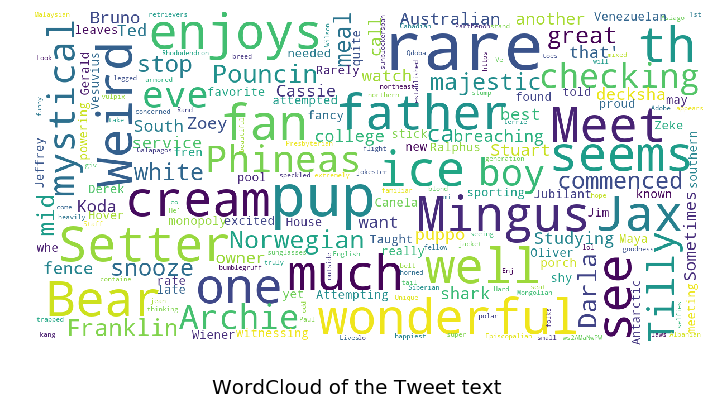

In [79]:
## Credit to StackOverflow Article: https://stackoverflow.com/a/48750930

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None, pngfile = "wordcloud.png"):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    
    plt.savefig(pngfile)
    plt.imshow(wordcloud)
    
    plt.show()
    

stopwords.update(['gets','dog',"Oh"])
#show_wordcloud(Samsung_Reviews_Negative['Reviews'])
show_wordcloud(merged_master_data["text"], title = "WordCloud of the Tweet text")


Some of the words that appear popular in the dataset are "Mingus" , "Canela", "Jax" (likely dog names). There are also other words such as "Norwegian", "fancy", :cream","pup","Bear"

In [80]:
merged_master_data.dog_stage.value_counts()

None             1704
pupper            204
doggo              66
puppo              24
doggo-pupper        9
floofer             7
doggo-floofer       1
doggo-puppo         1
Name: dog_stage, dtype: int64

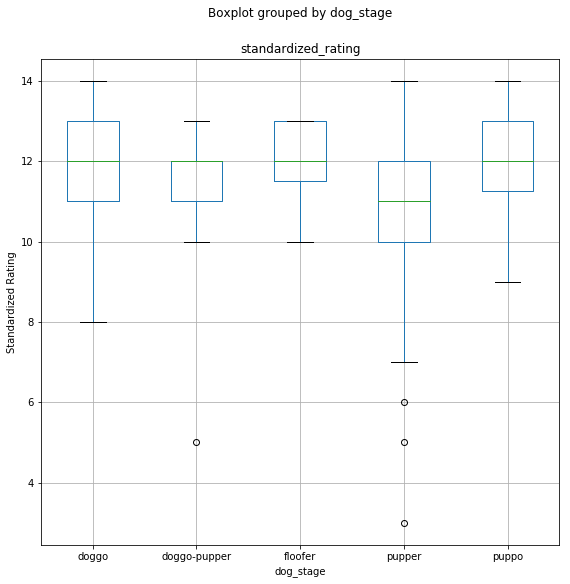

In [81]:
fig,ax = plt.subplots(figsize = (9,9))
plt.title("Distribution of Ratings versus dog_stages")
data = merged_master_data[["tweet_id","standardized_rating","dog_stage"]]
data = data[~data.duplicated()]
data = data[~data["dog_stage"].isin(["None","doggo-puppo","doggo-floofer"])]
data.boxplot(column="standardized_rating",by="dog_stage",ax=ax)
plt.ylabel("Standardized Rating")
plt.savefig("Boxplot1.png")


Of the different dog stages, it appears that the 'doggo' followed by dogs in the 'puppo' stage on average appears to have a  rating higher than the dogs in the other stages.

**Does the online community promote or tweet more for dogs with higher ratings?**

In [82]:
data["standardized_rating"].quantile([0,0.33,0.66,1])

0.00     3.0
0.33    10.0
0.66    12.0
1.00    14.0
Name: standardized_rating, dtype: float64

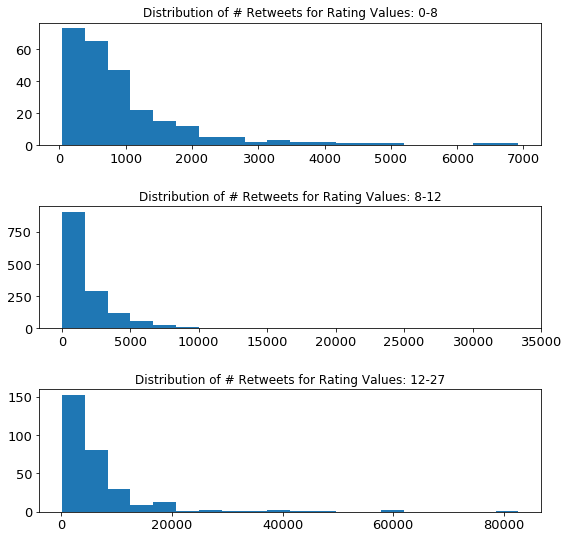

In [84]:
fig,axes = plt.subplots(3,1, figsize = (9,9))

data = merged_master_data[["tweet_id","retweet_count","favorite_count","standardized_rating"]]
data = data[~data.duplicated()]
bin_edges = [0,8,12,27]
rating_names = ["Poor","Good","Great"]
data["rating_category"] = pd.cut(data["standardized_rating"], bins=bin_edges, labels=rating_names)


for ind,ax in enumerate(axes):
    
    sub_data = data.loc[data["rating_category"] == rating_names[ind]]
    ax.hist(x=sub_data["retweet_count"],bins=20)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis="y",labelsize = 13)
    ax.set_title("Distribution of # Retweets for Rating Values: {}-{}".format(str(bin_edges[ind]), str(bin_edges[ind+1])))

plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig("RetweetDistribution.png")


    
    

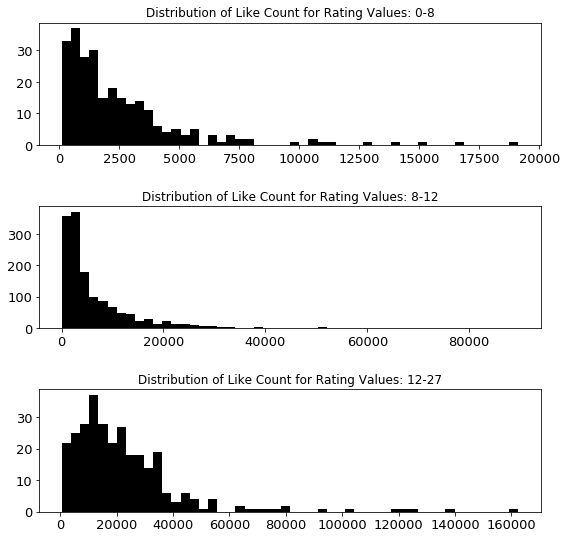

In [85]:
fig,axes = plt.subplots(3,1, figsize = (9,9))

for ind,ax in enumerate(axes):
    
    sub_data = data.loc[data["rating_category"] == rating_names[ind]]
    ax.hist(x=sub_data["favorite_count"],bins=50,color='k')
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis="y",labelsize = 13)
    ax.set_title("Distribution of Like Count for Rating Values: {}-{}".format(str(bin_edges[ind]), str(bin_edges[ind+1])))

plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig("LikesDistribution.png")


What are the popular dog breeds that were given a rating more than 10?

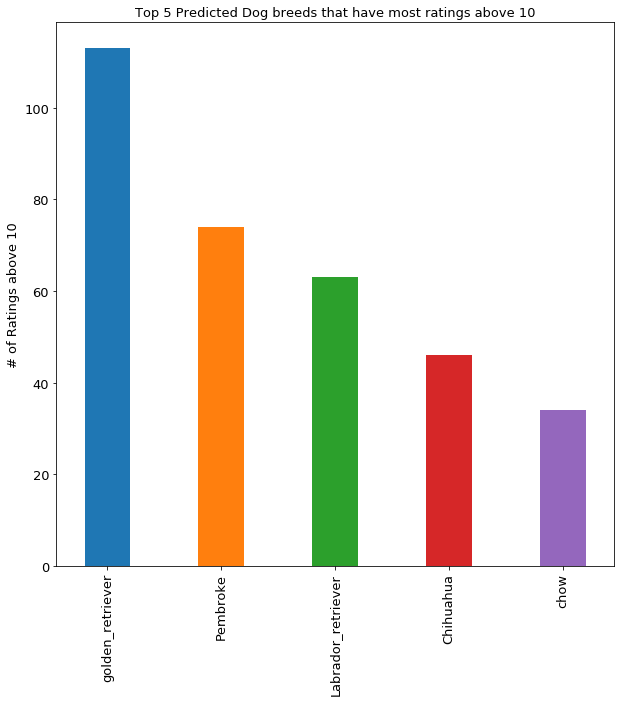

In [86]:
data = merged_master_data[["tweet_id","standardized_rating","p1","p1_conf"]]
data = data[~data.duplicated()]
data["GoodDogs"] = data.standardized_rating > 10

value_counts = data[data["standardized_rating"] > 10].p1.value_counts()
top_5_dogs = value_counts[:5]
fig,ax = plt.subplots(figsize=(10,10))

top_5_dogs.plot(kind="bar",ax=ax,width = 0.4)
ax.set_ylabel("# of Ratings above 10",fontsize = 13)
ax.set_title("Top 5 Predicted Dog breeds that have most ratings above 10",fontsize=13)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis="y",labelsize = 13)
plt.savefig("Top5Dogbreeds.png")


**Common Dog names in the dataset**

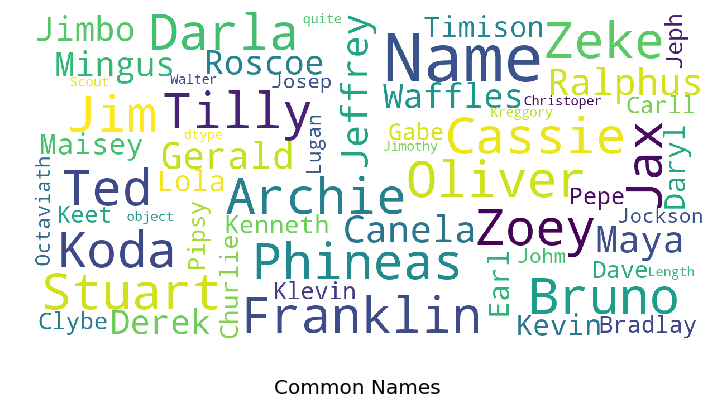

In [87]:
data = merged_master_data[["tweet_id","name"]]
data = data[~data.duplicated()]
data = data[~data.name.isin(["None","a"])]
show_wordcloud(data["name"],title="Common Names",pngfile="common_names_wordcloud.png")

Some of the most common dog names appear to be Oliver, Cooper, Lucy, Charlier, Tucker, Penny.

In [88]:
data.name.value_counts()

Cooper        10
Oliver        10
Charlie       10
Lucy          10
Tucker         9
Penny          9
Winston        8
Sadie          8
Lola           7
Daisy          7
the            7
Toby           7
Stanley        6
Jax            6
Koda           6
an             6
Bella          6
Bo             6
Milo           5
Bailey         5
Chester        5
Scout          5
Louis          5
Dave           5
Leo            5
Rusty          5
Buddy          5
Oscar          5
Gary           4
Scooter        4
              ..
Hamrick        1
Fynn           1
Laika          1
Alexander      1
Roscoe         1
 Octaviath     1
Cedrick        1
Amy            1
Mary           1
Lambeau        1
Iggy           1
Simba          1
Ralphus        1
Berkeley       1
Rodney         1
Livvie         1
Dobby          1
Ralf           1
 Quizno        1
Tobi           1
Steve          1
 Pepe          1
Pip            1
Hero           1
Jim            1
Tove           1
Banjo          1
Kirk          